## Line & Node Detection Playground

In this notebook, we will:
1. Load our raw and cleaned schematic images.  
2. Run a Hough-based line detector on the cleaned image.  
3. Visualize detected line segments overlaid on the schematic.  

Later cells will implement intersections, clustering, and node extraction.


In [1]:
# %%
# 1) Setup imports and module path
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path

# This notebook lives in project_root/notebooks/
notebooks_dir = Path.cwd()
project_root  = notebooks_dir.parent

# Add line_processing/scripts to PYTHONPATH
scripts_dir = project_root / "line_processing" / "scripts"
sys.path.insert(0, str(scripts_dir))

# Import our Hough detector
from hough_detection import detect_lines

# Point to the processed data root
processed_root = project_root / "data" / "processed"

# Gather all image-ID directories
img_dirs = [d for d in processed_root.iterdir() if d.is_dir()]
print(f"Found {len(img_dirs)} image folders.")


Found 17 image folders.


In [2]:
# %%
# 3) Loop over each image folder, auto-detect raw vs. cleaned
for img_dir in img_dirs:
    img_id = img_dir.name

    # 3.1) Find cleaned.png
    cleaned_path = img_dir / "cleaned.png"
    if not cleaned_path.exists():
        print(f"⚠️ cleaned.png missing in {img_id}, skipping.")
        continue

    # 3.2) Try to find raw.png in processed folder
    raw_candidates = [p for p in img_dir.glob("*.png") if p.name != "cleaned.png"]
    if raw_candidates:
        raw_path = raw_candidates[0]
    else:
        # Fallback to data/raw/{img_id}.png
        fallback = project_root / "data" / "raw" / f"{img_id}.png"
        if fallback.exists():
            raw_path = fallback
        else:
            print(f"⚠️ No raw image for {img_id} (neither in processed nor in data/raw), skipping.")
            continue

    # Load images
    raw   = cv2.imread(str(raw_path),   cv2.IMREAD_GRAYSCALE)
    clean = cv2.imread(str(cleaned_path), cv2.IMREAD_GRAYSCALE)

    # Binarize the cleaned image (wires white on black)
    _, binary = cv2.threshold(clean, 127, 255, cv2.THRESH_BINARY_INV)

    # Detect line segments
    segments = detect_lines(
        binary,
        rho=1,
        theta=np.pi/180,
        threshold=50,
        min_line_length=15,
        max_line_gap=10
    )
    

    # Overlay segments for visual check
    overlay = cv2.cvtColor(clean, cv2.COLOR_GRAY2BGR)
    for x1, y1, x2, y2 in segments:
        cv2.line(overlay, (x1, y1), (x2, y2), (0, 0, 255), 1)






### Random Sample of Raw Hough Overlays

Here we randomly pick five image folders, load their `segments.json`, draw the raw Hough lines (in red) on `cleaned.png`, and plot them for inspection.


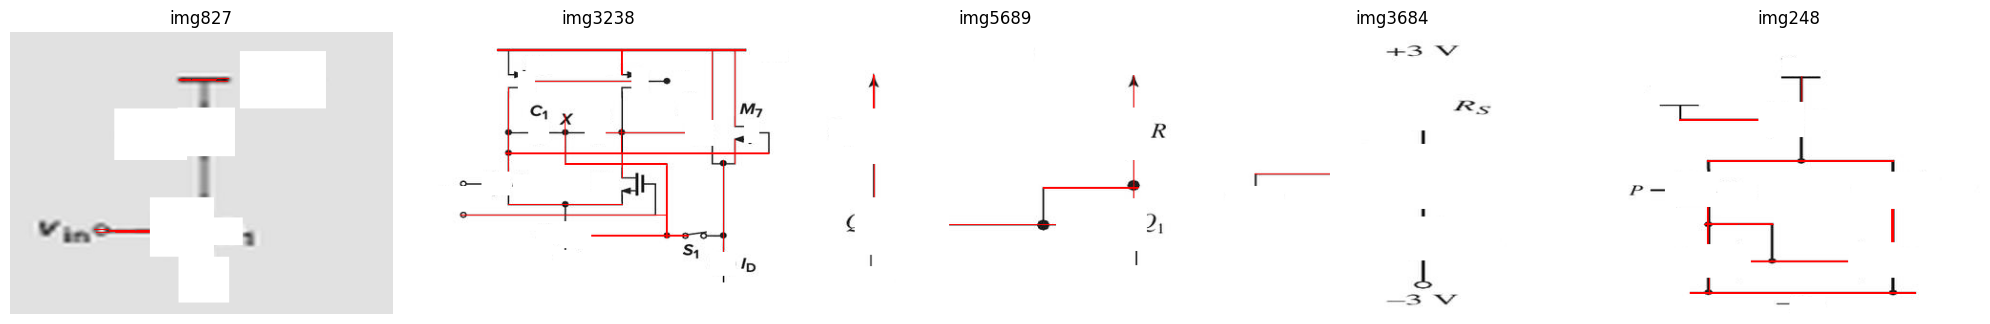

In [3]:
# %%
import random
import json
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

# Root of your processed data
processed_root = Path.cwd().parent / "data" / "processed"

# Gather all folders that have a segments.json
folders = []
for img_dir in processed_root.iterdir():
    seg_file = img_dir / "line_results" / "segments.json"
    if seg_file.exists():
        folders.append(img_dir)

# Randomly sample up to 5
sample_folders = random.sample(folders, min(5, len(folders)))

# Plot them
fig, axs = plt.subplots(1, len(sample_folders), figsize=(4 * len(sample_folders), 4))
if len(sample_folders) == 1:
    axs = [axs]

for ax, img_dir in zip(axs, sample_folders):
    # Load cleaned image
    clean = cv2.imread(str(img_dir / "cleaned.png"), cv2.IMREAD_GRAYSCALE)
    overlay = cv2.cvtColor(clean, cv2.COLOR_GRAY2BGR)

    # Load segments
    with open(img_dir / "line_results" / "segments.json") as f:
        segments = json.load(f)
    # Draw raw Hough lines in red
    for x1, y1, x2, y2 in segments:
        cv2.line(overlay, (x1, y1), (x2, y2), (0, 0, 255), 1)

    # Convert BGR→RGB for matplotlib
    img_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
    ax.imshow(img_rgb)
    ax.set_title(img_dir.name)
    ax.axis("off")

plt.tight_layout()
plt.show()


### 5) Split Segments by Orientation

We’ll use our new `split_by_orientation()` utility to classify and then color-code horizontals vs. verticals:
- **Blue** = horizontal  
- **Green** = vertical


In [4]:
# %%
from segment import split_by_orientation

# Split the already-detected `segments` into two lists
horizontals, verticals = split_by_orientation(segments, angle_thresh=45.0)

print(f"Found {len(horizontals)} horizontal and {len(verticals)} vertical segments.")

# Visualize: blue for horizontal, green for vertical
overlay_orient = cv2.cvtColor(clean, cv2.COLOR_GRAY2BGR)
for x1, y1, x2, y2 in horizontals:
    cv2.line(overlay_orient, (x1, y1), (x2, y2), (255, 0, 0), 1)  # blue
for x1, y1, x2, y2 in verticals:
    cv2.line(overlay_orient, (x1, y1), (x2, y2), (0, 255, 0), 1)  # green



Found 10 horizontal and 7 vertical segments.


In [5]:
# %%
import json
import cv2
import matplotlib.pyplot as plt
from segment import split_by_orientation
from hough_detection import detect_lines

# Loop over each processed image folder
for img_dir in img_dirs:
    img_id = img_dir.name

    # 1) Identify cleaned.png and raw.png
    cleaned_path = img_dir / "cleaned.png"
    raw_cands    = [p for p in img_dir.glob("*.png") if p.name != "cleaned.png"]
    if raw_cands:
        raw_path = raw_cands[0]
    else:
        # fallback to data/raw/{img_id}.png
        fallback = project_root / "data" / "raw" / f"{img_id}.png"
        if fallback.exists():
            raw_path = fallback
        else:
            print(f"⚠️ {img_id}: no raw image, skipping")
            continue

    # 2) Load images
    clean = cv2.imread(str(cleaned_path), cv2.IMREAD_GRAYSCALE)
    raw   = cv2.imread(str(raw_path),   cv2.IMREAD_GRAYSCALE)

    # 3) Hough line detection
    _, binary = cv2.threshold(clean, 127, 255, cv2.THRESH_BINARY_INV)
    segments = detect_lines(
        binary, rho=1, theta=np.pi/180,
        threshold=50, min_line_length=15, max_line_gap=10
    )

    # 4) Split into horizontals/verticals
    horizontals, verticals = split_by_orientation(segments, angle_thresh=45.0)

    # 5) Create overlay image
    overlay = cv2.cvtColor(clean, cv2.COLOR_GRAY2BGR)
    for x1,y1,x2,y2 in horizontals:
        cv2.line(overlay, (x1, y1), (x2, y2), (255, 0, 0), 1)
    for x1,y1,x2,y2 in verticals:
        cv2.line(overlay, (x1, y1), (x2, y2), (0, 255, 0), 1)

   

    # 7) Save results to disk
    results_dir = img_dir / "line_results"
    results_dir.mkdir(exist_ok=True)

    # Save segment lists
    with open(results_dir / "segments.json", "w") as f:
        json.dump(segments, f, indent=2)
    with open(results_dir / "horizontals.json", "w") as f:
        json.dump(horizontals, f, indent=2)
    with open(results_dir / "verticals.json", "w") as f:
        json.dump(verticals, f, indent=2)

    # Save overlay image
    cv2.imwrite(str(results_dir / "overlay.png"), overlay)

  



### Random Sample of 5 Overlays

Below we randomly select up to five `overlay.png` images from each `line_results` folder and display them side by side for quick inspection.


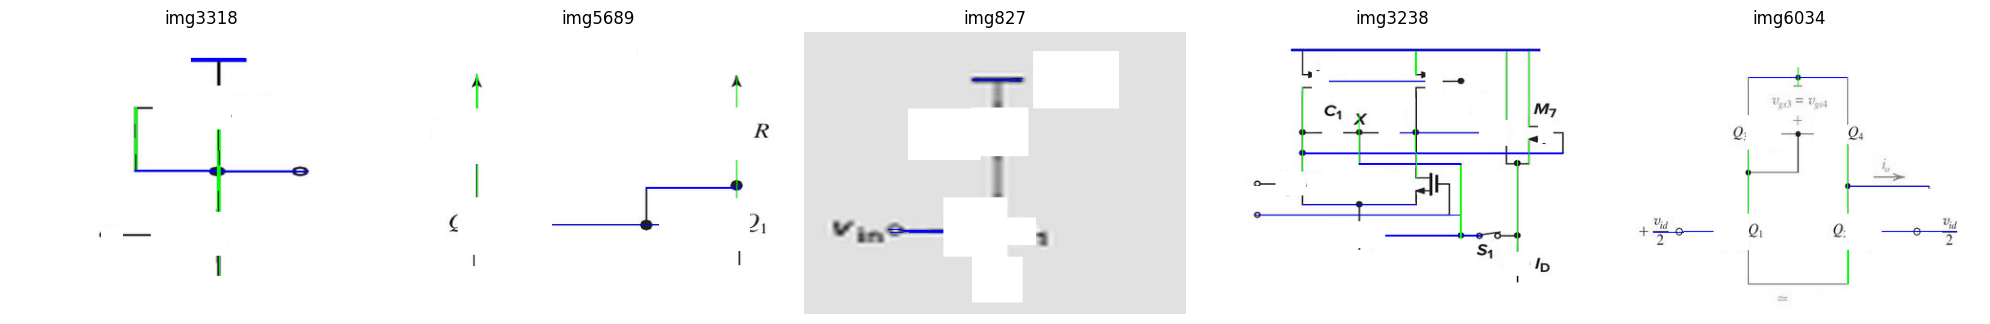

In [6]:
# %%
import random
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

# Root of your processed data
processed_root = Path.cwd().parent / "data" / "processed"

# Gather all overlay.png paths
overlay_paths = []
for img_dir in processed_root.iterdir():
    p = img_dir / "line_results" / "overlay.png"
    if p.exists():
        overlay_paths.append(p)

# Sample up to 5 overlays
sample_paths = random.sample(overlay_paths, min(5, len(overlay_paths)))

# Plot them
fig, axs = plt.subplots(1, len(sample_paths), figsize=(4 * len(sample_paths), 4))
if len(sample_paths) == 1:
    axs = [axs]

for ax, p in zip(axs, sample_paths):
    img = cv2.imread(str(p))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_title(p.parent.parent.name)  # image ID as title
    ax.axis("off")

plt.tight_layout()
plt.show()


### 6) Compute Intersections → Node Candidates

We’ll import `segmented_intersections()` to find all crossing points between our horizontal and vertical segments.  
These points are candidate nodes (junctions) in the schematic.


In [7]:
# %%
import json
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from intersections import segmented_intersections

# Locate all processed image folders
processed_root = Path.cwd().parent / "data" / "processed"
img_dirs       = [d for d in processed_root.iterdir() if d.is_dir()]

for img_dir in img_dirs:
    lr = img_dir / "line_results"
    hfile = lr / "horizontals.json"
    vfile = lr / "verticals.json"
    if not (hfile.exists() and vfile.exists()):
        print(f"⚠️ Skipping {img_dir.name}: missing horizontals/verticals")
        continue

    # Load segment lists
    horizontals = json.loads(hfile.read_text())
    verticals   = json.loads(vfile.read_text())

    # Compute intersections
    nodes = segmented_intersections(horizontals, verticals)
    

    # Save intersections.json
    (lr / "intersections.json").write_text(json.dumps(nodes, indent=2))

    # Load cleaned image for overlay
    clean = cv2.imread(str(img_dir / "cleaned.png"), cv2.IMREAD_GRAYSCALE)
    overlay = cv2.cvtColor(clean, cv2.COLOR_GRAY2BGR)
    for x, y in nodes:
        cv2.circle(overlay, (x, y), radius=3, color=(0, 255, 255), thickness=-1)

    # Save visualization
    cv2.imwrite(str(lr / "nodes.png"), overlay)
    


### Random Sample of 5 Intersection Visualizations

Below we randomly select up to five `nodes.png` images (yellow‐dot overlays) from each `line_results` folder and display them side by side.


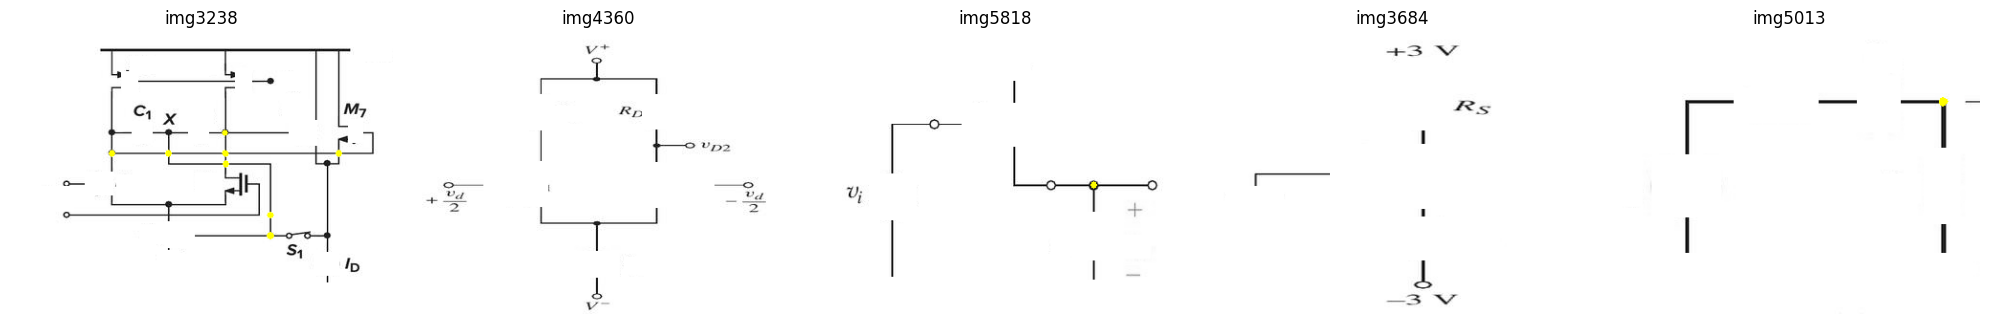

In [8]:
# %%
import random
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

# Root of your processed data
processed_root = Path.cwd().parent / "data" / "processed"

# Gather all nodes.png paths
nodes_paths = []
for img_dir in processed_root.iterdir():
    p = img_dir / "line_results" / "nodes.png"
    if p.exists():
        nodes_paths.append(p)

# Sample up to 5
sample_paths = random.sample(nodes_paths, min(5, len(nodes_paths)))

# Plot them
fig, axs = plt.subplots(1, len(sample_paths), figsize=(4 * len(sample_paths), 4))
if len(sample_paths) == 1:
    axs = [axs]

for ax, p in zip(axs, sample_paths):
    img = cv2.imread(str(p))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_title(p.parent.parent.name)  # show the image ID
    ax.axis("off")

plt.tight_layout()
plt.show()


### 7) Cluster Intersection Points into True Nodes

We cluster any nearby intersection points (within 5 px) into consolidated nodes.  
This handles the case where some images have no intersections gracefully.


In [9]:
# %%
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from node_clustering import cluster_nodes

processed_root = Path.cwd().parent / "data" / "processed"
img_dirs       = [d for d in processed_root.iterdir() if d.is_dir()]

for img_dir in img_dirs:
    lr = img_dir / "line_results"
    inter_file = lr / "intersections.json"
    if not inter_file.exists():
        print(f"⚠️ Skipping {img_dir.name}: no intersections.json")
        continue

    # Load raw intersections
    raw_pts = json.loads(inter_file.read_text())
    if not raw_pts:
       
        clustered = []
    else:
        # Cluster them
        clustered = cluster_nodes(raw_pts, threshold=5.0)
        

    # Save clustered nodes
    (lr / "clustered_nodes.json").write_text(json.dumps(clustered, indent=2))

    # Visualize on the cleaned image
    clean = cv2.imread(str(img_dir / "cleaned.png"), cv2.IMREAD_GRAYSCALE)
    overlay = cv2.cvtColor(clean, cv2.COLOR_GRAY2BGR)

    # Draw clustered nodes (magenta)
    for x, y in clustered:
        cv2.circle(overlay, (x, y), radius=4, color=(255, 0, 255), thickness=-1)

    # Save visualization
    cv2.imwrite(str(lr / "clustered_nodes.png"), overlay)
   


### Random Sample of 5 Clustered Node Overlays

Here we randomly select up to five `clustered_nodes.png` images (magenta‐dot overlays) from each `line_results` folder and display them side by side for quick inspection.


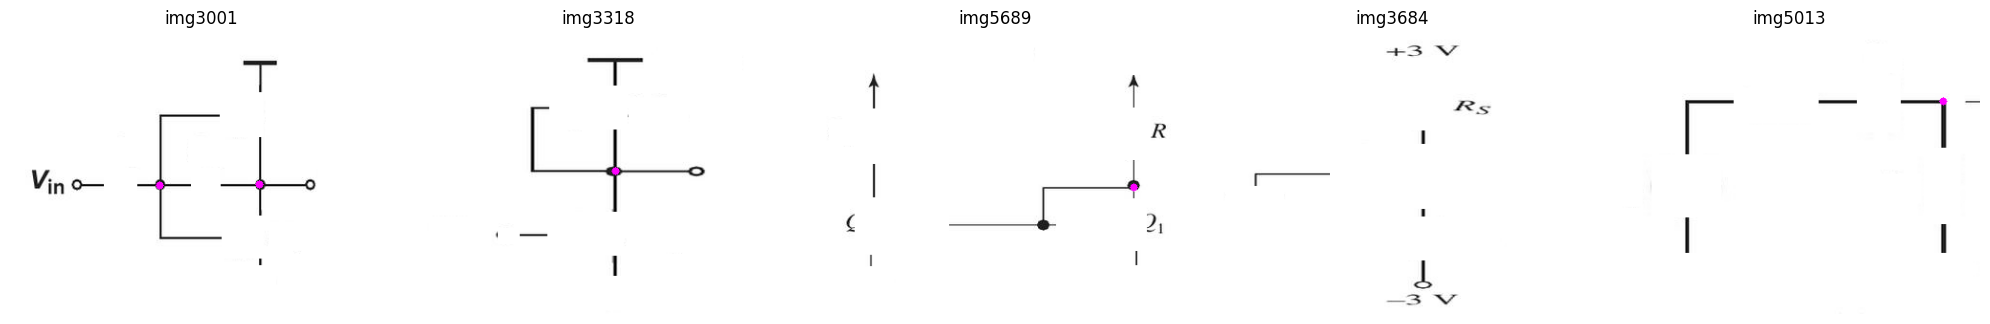

In [10]:
# %%
import random
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

# Root of your processed data
processed_root = Path.cwd().parent / "data" / "processed"

# Gather all clustered_nodes.png paths
clustered_paths = []
for img_dir in processed_root.iterdir():
    p = img_dir / "line_results" / "clustered_nodes.png"
    if p.exists():
        clustered_paths.append(p)

# Sample up to 5
sample_paths = random.sample(clustered_paths, min(5, len(clustered_paths)))

# Create subplots
fig, axs = plt.subplots(1, len(sample_paths), figsize=(4 * len(sample_paths), 4))
if len(sample_paths) == 1:
    axs = [axs]

# Plot each sampled overlay
for ax, p in zip(axs, sample_paths):
    img = cv2.imread(str(p))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_title(p.parent.parent.name)  # image ID
    ax.axis("off")

plt.tight_layout()
plt.show()


### 7) Refined Terminal Detection (Contour + Mask-XOR)

We fill in component bboxes → subtract wires → find contours → keep the 2 × N largest  
centroids as our component terminal locations.  


In [12]:
# %%
import json
import cv2
from pathlib import Path
from terminal_detection import detect_terminals_refined

# Setup roots
project_root   = Path.cwd().parent
processed_root = project_root / "data" / "processed"
raw_root       = project_root / "data" / "raw"

img_dirs = [d for d in processed_root.iterdir() if d.is_dir()]

for img_dir in img_dirs:
    img_id = img_dir.name
    lr     = img_dir / "line_results"
    lr.mkdir(exist_ok=True, parents=True)

    # locate raw image (.jpg or .png)
    raw_file = None
    for ext in (".jpg",".png"):
        p = raw_root / f"{img_id}{ext}"
        if p.exists():
            raw_file = p; break
    if raw_file is None:
        print(f"⚠️ {img_id}: raw image not found, skipping")
        continue

    raw = cv2.imread(str(raw_file), cv2.IMREAD_GRAYSCALE)
    comp_json = img_dir / "components.json"
    if not comp_json.exists():
        print(f"⚠️ {img_id}: components.json missing")
        continue

    terminals = detect_terminals_refined(raw, comp_json,
                                         thresh_block=11, thresh_C=2)
    

    # save
    with open(lr / "comp_terminals.json","w") as f:
        json.dump(terminals, f, indent=2)

    # overlay for debug
    overlay = cv2.cvtColor(raw, cv2.COLOR_GRAY2BGR)
    for x,y in terminals:
        cv2.circle(overlay,(x,y),4,(0,255,0),-1)
    cv2.imwrite(str(lr/"terminals.png"), overlay)
   


In [15]:
raw = cv2.imread(raw_path)
cleaned = cv2.imread(str(img_dir/"cleaned.png"))
print("raw shape:    ", raw.shape[:2])
print("cleaned shape:", cleaned.shape[:2])


raw shape:     (295, 400)
cleaned shape: (295, 400)


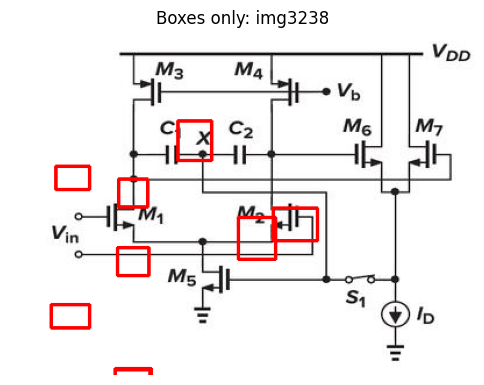

In [16]:
# DEBUG: draw only boxes on raw
import cv2
from pathlib import Path

raw = cv2.imread(str(raw_path), cv2.IMREAD_COLOR)
debug = raw.copy()
boxes = json.loads((img_dir/"components.json").read_text())

for e in boxes:
    raw_bbox = e["bbox"]
    # assume [y1,x1,y2,x2]—unpack accordingly
    y1,x1,y2,x2 = raw_bbox
    cv2.rectangle(debug, (int(x1),int(y1)), (int(x2),int(y2)), (0,0,255), 2)

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(debug, cv2.COLOR_BGR2RGB))
plt.title(f"Boxes only: {img_id}")
plt.axis("off")
plt.show()


In [17]:
# %%
from pathlib import Path
import json

# Load a single image’s components.json
img_dir = Path.cwd().parent / "data" / "processed" / "img3001"
entries = json.loads((img_dir / "components.json").read_text())

print("First 5 entries in components.json:")
for e in entries[:5]:
    print(e)


First 5 entries in components.json:
{'label': 'MOSFET', 'bbox': [218, 189, 268, 240]}
{'label': 'Capacitor', 'bbox': [187, 139, 222, 183]}
{'label': 'MOSFET', 'bbox': [215, 60, 269, 113]}
{'label': 'Capacitor', 'bbox': [96, 139, 135, 184]}
{'label': 'Ground', 'bbox': [243, 241, 279, 290]}


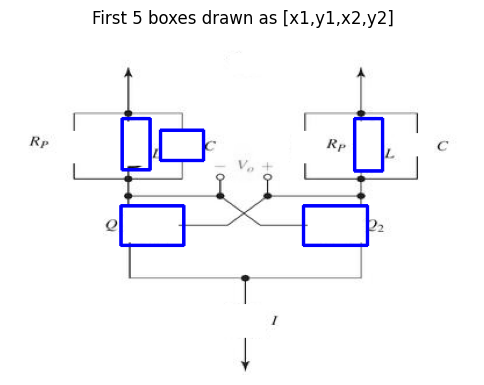

In [19]:
# %%
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import json

img_dir = Path.cwd().parent / "data" / "processed" / "img6388"

# Load cleaned and boxes
cleaned = cv2.imread(str(img_dir / "cleaned.png"), cv2.IMREAD_GRAYSCALE)
entries = json.loads((img_dir / "components.json").read_text())

overlay = cv2.cvtColor(cleaned, cv2.COLOR_GRAY2BGR)

for e in entries[:5]:   # first five only for clarity
    raw_bbox = e["bbox"]
    # try interpreting as [x1,y1,x2,y2]
    x1,y1,x2,y2 = raw_bbox
    cv2.rectangle(overlay, (int(x1),int(y1)), (int(x2),int(y2)), (0,0,255), 2)

plt.figure(figsize=(6,6))
plt.imshow(overlay)
plt.title("First 5 boxes drawn as [x1,y1,x2,y2]")
plt.axis("off")
plt.show()


In [20]:
# Load images
cleaned = cv2.imread(str(img_dir / "cleaned.png"), cv2.IMREAD_GRAYSCALE)
raw     = cv2.imread(str(raw_path), cv2.IMREAD_COLOR)

h_clean, w_clean = cleaned.shape[:2]
h_raw,   w_raw   = raw.shape[:2]

scale_x = w_raw  / w_clean
scale_y = h_raw  / h_clean

print(f"{img_id}: cleaned size = ({w_clean}×{h_clean}), raw size = ({w_raw}×{h_raw})")
print(f"Scale factors → x: {scale_x:.3f},  y: {scale_y:.3f}")


img3238: cleaned size = (400×295), raw size = (400×295)
Scale factors → x: 1.000,  y: 1.000


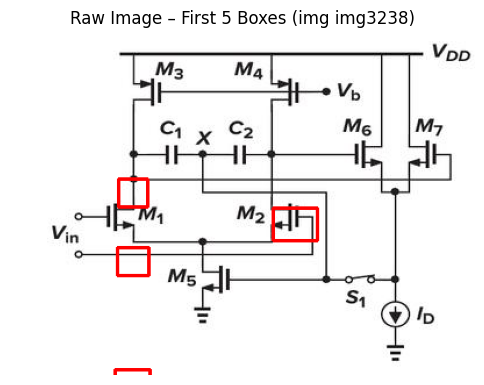

In [21]:
# %%
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import json

# Pick one image folder
img_id  = "img3238"   # change this to test other images
img_dir = Path.cwd().parent / "data" / "processed" / img_id

# Load raw schematic
raw_root = Path.cwd().parent / "data" / "raw"
# find the actual raw file (.jpg/.png)
raw_path = None
for ext in (".jpg",".png"):
    cand = raw_root / f"{img_id}{ext}"
    if cand.exists():
        raw_path = cand
        break

raw = cv2.imread(str(raw_path), cv2.IMREAD_COLOR)
debug = raw.copy()

# Load first 5 boxes
entries = json.loads((img_dir / "components.json").read_text())
for e in entries[:5]:
    y1, x1, y2, x2 = e["bbox"]   # use the unpacking that worked on cleaned
    # draw on debug raw
    cv2.rectangle(debug, (int(x1),int(y1)), (int(x2),int(y2)), (0,0,255), 2)

# Show result
plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(debug, cv2.COLOR_BGR2RGB))
plt.title(f"Raw Image – First 5 Boxes (img {img_id})")
plt.axis("off")
plt.show()


### 8) Map Terminals to Nodes on Raw Schematic & Draw Component Boxes

We now load the **raw schematic** plus each component’s boxes (from `components.json`),  
then draw:
- **Orange** rectangles for component boxes  
aæa- **Green** dots for each terminal

→ Saved mapping_overlay.png in /Users/fatihbasturk/Projects/EE58A-2025/data/processed/img6301/line_results


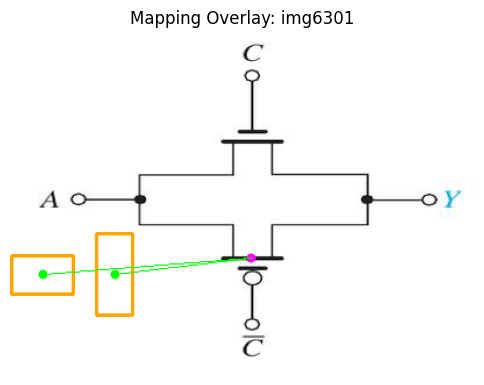

→ Saved mapping_overlay.png in /Users/fatihbasturk/Projects/EE58A-2025/data/processed/img248/line_results


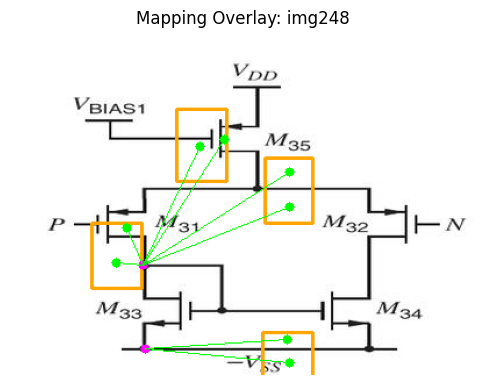

→ Saved mapping_overlay.png in /Users/fatihbasturk/Projects/EE58A-2025/data/processed/img4360/line_results


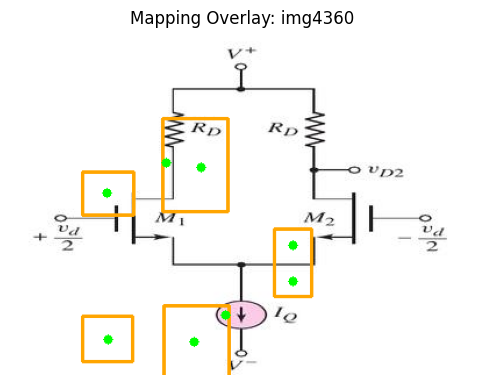

→ Saved mapping_overlay.png in /Users/fatihbasturk/Projects/EE58A-2025/data/processed/img3001/line_results


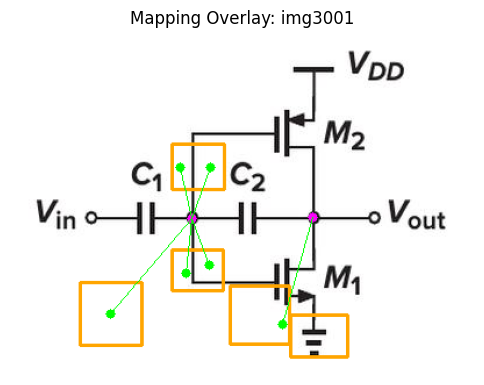

→ Saved mapping_overlay.png in /Users/fatihbasturk/Projects/EE58A-2025/data/processed/img3684/line_results


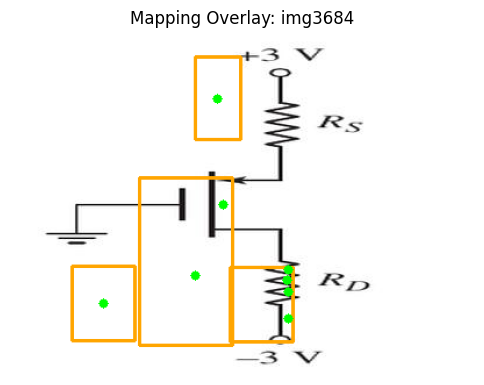

→ Saved mapping_overlay.png in /Users/fatihbasturk/Projects/EE58A-2025/data/processed/img145/line_results


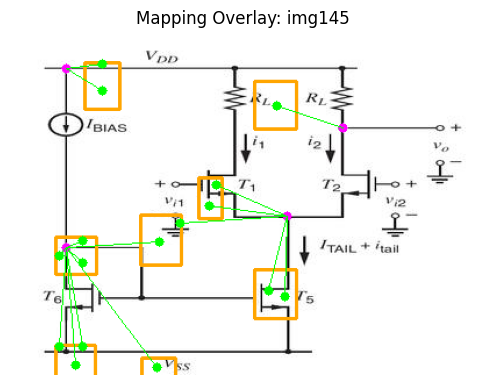

→ Saved mapping_overlay.png in /Users/fatihbasturk/Projects/EE58A-2025/data/processed/img4668/line_results


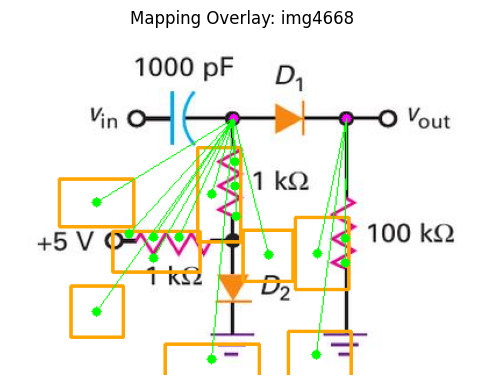

→ Saved mapping_overlay.png in /Users/fatihbasturk/Projects/EE58A-2025/data/processed/img5013/line_results


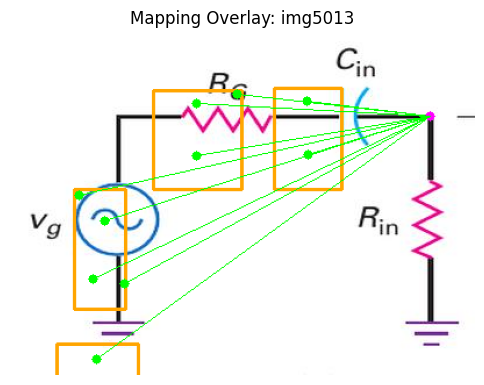

→ Saved mapping_overlay.png in /Users/fatihbasturk/Projects/EE58A-2025/data/processed/img6034/line_results


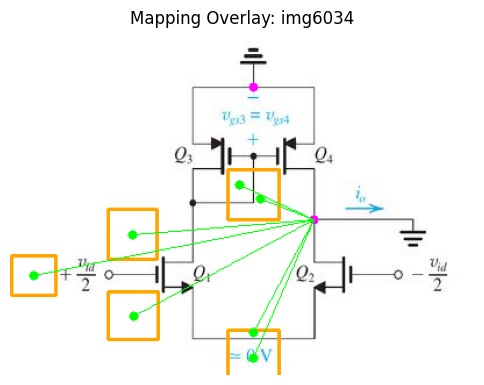

→ Saved mapping_overlay.png in /Users/fatihbasturk/Projects/EE58A-2025/data/processed/img5689/line_results


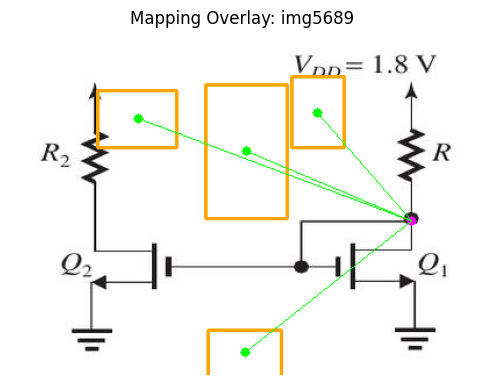

→ Saved mapping_overlay.png in /Users/fatihbasturk/Projects/EE58A-2025/data/processed/img827/line_results


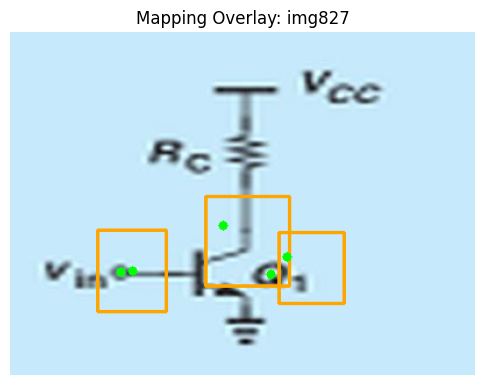

→ Saved mapping_overlay.png in /Users/fatihbasturk/Projects/EE58A-2025/data/processed/img5688/line_results


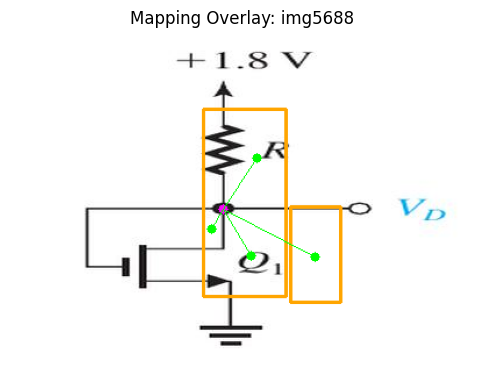

→ Saved mapping_overlay.png in /Users/fatihbasturk/Projects/EE58A-2025/data/processed/img3318/line_results


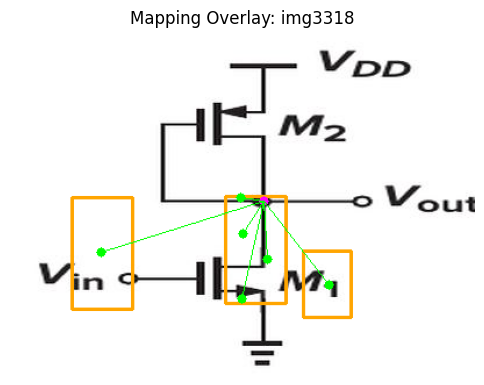

→ Saved mapping_overlay.png in /Users/fatihbasturk/Projects/EE58A-2025/data/processed/img5818/line_results


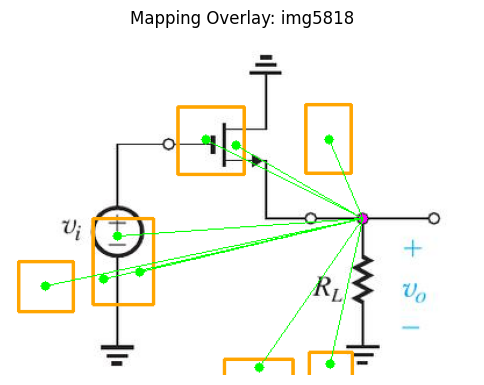

→ Saved mapping_overlay.png in /Users/fatihbasturk/Projects/EE58A-2025/data/processed/img4561/line_results


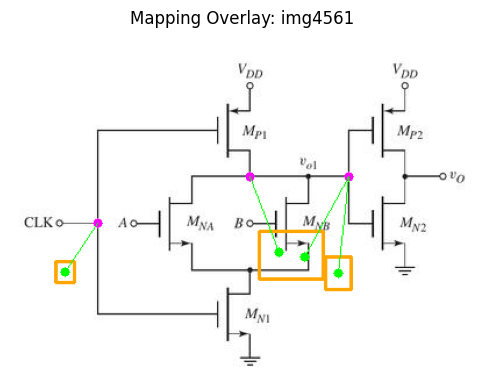

→ Saved mapping_overlay.png in /Users/fatihbasturk/Projects/EE58A-2025/data/processed/img6388/line_results


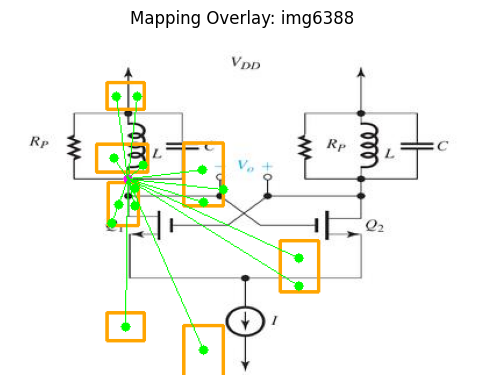

→ Saved mapping_overlay.png in /Users/fatihbasturk/Projects/EE58A-2025/data/processed/img3238/line_results


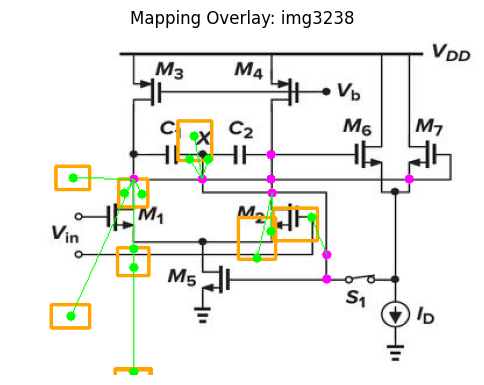

In [14]:
# %%
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from mapping import map_terminals_to_nodes

project_root   = Path.cwd().parent
processed_root = project_root / "data" / "processed"
raw_root       = project_root / "data" / "raw"

for img_dir in processed_root.iterdir():
    if not img_dir.is_dir(): 
        continue
    img_id   = img_dir.name
    lr       = img_dir / "line_results"
    term_file= lr / "comp_terminals.json"
    node_file= lr / "clustered_nodes.json"
    comp_file= img_dir / "components.json"

    # Skip if missing
    if not (term_file.exists() and node_file.exists() and comp_file.exists()):
        print(f"⚠️ Skipping {img_id}: missing one of comp_terminals, clustered_nodes, or components.json")
        continue

    # Find raw schematic
    raw_path = None
    for ext in (".jpg", ".png"):
        p = raw_root / f"{img_id}{ext}"
        if p.exists():
            raw_path = p; break
    if raw_path is None:
        print(f"⚠️ {img_id}: raw schematic not found")
        continue

    # Load raw image in color
    raw = cv2.imread(str(raw_path), cv2.IMREAD_COLOR)
    overlay = raw.copy()

    # Draw component boxes (orange)
    boxes = json.loads(comp_file.read_text())
    for entry in boxes:
        raw_bbox = entry["bbox"]
        # normalize bbox format
        if isinstance(raw_bbox, list) and len(raw_bbox)==4:
            y1, x1, y2, x2 = raw_bbox
        elif isinstance(raw_bbox, list) and len(raw_bbox)==2:
            (y1,x1),(y2,x2) = raw_bbox
        else:
            raw_bbox = entry["bbox"]
            y1, x1, y2, x2 = raw_bbox["y1"], raw_bbox["x1"], raw_bbox["y2"], raw_bbox["x2"]
        cv2.rectangle(overlay, (int(x1),int(y1)), (int(x2),int(y2)), (0,165,255), 2)

    # Load terminals and nodes
    terminals = [tuple(pt) for pt in json.loads(term_file.read_text())]
    nodes     = [tuple(pt) for pt in json.loads(node_file.read_text())]

    # Map terminals → nodes
    term2node = map_terminals_to_nodes(terminals, nodes)
    (lr / "terminal_node_map.json").write_text(json.dumps(term2node, indent=2))

    # Draw terminals (green) and nodes (magenta) + connecting lines
    for (tx,ty) in terminals:
        cv2.circle(overlay, (tx,ty), 4, (0,255,0), -1)
    for (nx,ny) in nodes:
        cv2.circle(overlay, (nx,ny), 4, (255,0,255), -1)
    for (tx,ty), nid in zip(terminals, term2node):
        if nid >= 0:
            nx, ny = nodes[nid]
            cv2.line(overlay, (tx,ty), (nx,ny), (0,255,0), 1)

    # Save and display
    out_img = lr / "mapping_overlay.png"
    cv2.imwrite(str(out_img), overlay)
    print(f"→ Saved mapping_overlay.png in {lr}")

    # (Optional) show one example
    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title(f"Mapping Overlay: {img_id}")
    plt.axis("off")
    plt.show()
